In [2]:
import os
import ROOT
import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from multihist import Hist1d, Histdd

from scipy.optimize import curve_fit
import scipy.stats as sps
%matplotlib inline

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['image.cmap'] = 'viridis'
#see the AP(copy) and save!!!!! the fit parameters (res)

In [3]:
path = "/home/cristian/Suxess_files/data/run2/gas/AP171027-reprocessed/"
#board=0
#channel=3
os.listdir(path)

['processed_wf6_Board0_AP_LED_2.12V.root',
 'processed_wf3_Board0_AP_LED_2.3V.root',
 'processed_wf5_Board0_AP_LED_2.09V.root',
 'processed_wf1_Board0_AP_LED_2.26V.root',
 'processed_wf0_Board0_AP_LED_2.205V.root',
 'processed_wf2_Board0_AP_LED_2.26V.root',
 'processed_wf4_Board0_AP_LED_2.3V.root']

In [4]:
elem_charge = 1.6021766e-19

def area_to_charge(a):
    # area in adc counts * 10 * ns
    factor = 2.25 * 10e-9 / (2**14 * 50) #  * elem_charge)
    return factor * (a / 10)

In [5]:
def process_ap_file(filename):
    file = ROOT.TFile(filename)
    tree = file.Get('T1')

    pos = []
    area = []
    #entropy = []
    height = []
    width50 = []
    evtnb =[]
    for event in tqdm(file.Get('T1')):
        if len(event.Position)>0:
            for p in event.Position:
                pos.append(p)
        if len(event.Area)>0:        
            for a in event.Area:
                area.append(a)
        #for e in event.Entropy:
          #  entropy.append(e)
        if len(event.Height)>0:
            for h in event.Height:
                height.append(h)
        if len(event.Width50)>0:
            for w in event.Width50:
                width50.append(w)
        #for ev in event.Evtnb:
            #evtnb.append(ev)not the same lenght of area, positio etc. It's only the total number of waveforms not number of peaks
    d = {'time': np.array(pos),
        'area': area_to_charge(np.array(area))/(5e6 * elem_charge),
        'height': np.array(height),
        'width50':np.array(width50)}#,
        #'event_number': np.array(evtnb)}
    df = pd.DataFrame(d)
    t0_df=df[df['area']>100]
    t0 = np.mean(t0_df.time)
    d={'time': np.array((pos-t0)/100),
       'area': area_to_charge(np.array(area))/(5e6 * elem_charge),
       'height': np.array(height),
       'width50': np.array(width50)}#,
       #'event_number': np.array(evtnb)}
    df = pd.DataFrame(d)
    #print (df[df['area']<0])
    #print(df[df['area']==0])
    return df

In [6]:
def estimateArPosition(V):
    R2 = 72.6e6 #resistence after photocatode
    R1 = 92.6e6 #Total resistence
    
    fV = V - (V*R2)/R1
    ArPeak = 29.4402*np.sqrt(1/fV)
    return ArPeak - 0.07

def estimateXePosition(V):
    R2 = 72.6e6 #resistence after photocatode
    R1 = 92.6e6 #Total resistence
    fV = V - (V*R2)/R1
    XePeak = 53.2778*np.sqrt(1/fV)
    return XePeak - 0.11



In [7]:
def plot_hw(data_frame, pmt):
    #data_frame = data_frame[(data_frame['area']>=0) & (data_frame['time']>-0.1)]
    plt.figure(figsize=(10,6))
    #data_frame1=data_frame[data_frame['entropy']<0.4]
    #print(data_frame)
    #data_frame1=data_frame[((data_frame['height']>300)|(data_frame['width50']<10))]
    plt.hist2d(data_frame['width50'], data_frame['height'], bins=(60,500), range=((0, 60), (0,500)), norm=LogNorm()) #bins 200
    plt.colorbar(label='counts')
    plt.xlabel('width (*10 ns)')
    plt.ylabel('height (ADC)')
    plt.title('PMT %d' % pmt)
    #plt.savefig(path+ 'AP_figs/' + 'ap_pmt%d_run2_gas.png' % pmt, dpi=150)
    plt.show()

In [8]:
def plot(data_frame, pmt, valHV5e6):
    #data_frame = data_frame[(data_frame['area']>=0) & (data_frame['time']>-0.1)]
    plt.figure(figsize=(10,6))
    #data_frame1=data_frame[((data_frame['height']<100)|(data_frame['width50']>4))]
    #print(data_frame)
    plt.hist2d(data_frame['time'], data_frame['area'], bins=(550,500), range=((-0.5, 5), (0,50)), norm=LogNorm()) #bins 200
    plt.colorbar(label='counts')
    XePeak = estimateXePosition(valHV5e6)
    ArPeak = estimateArPosition(valHV5e6)
    plt.axvline(ArPeak, color='b', linestyle='dashed', linewidth=2, label = 'expected Ar peak')
    plt.axvline(XePeak, color='red', linestyle='dashed', linewidth=2, label = 'expected Xe peak')
    plt.legend(loc = 'upper right')
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Area [pe]')
    plt.title('PMT %d' % pmt)
    #plt.savefig(path+ 'AP_figs/' + 'ap_pmt%d_run2_gas.png' % pmt, dpi=150, transparent= False)
    plt.show()

In [9]:
def to_pmt(board, channel):
    if board == 0:
        return channel + 1
    if board == 1 and channel==0:
        return 8
    if board ==1 and channel!=6:
        return channel+9

1365it [00:00, 13645.30it/s]

processed_wf6_Board0_AP_LED_2.12V.root


250000it [00:10, 23029.26it/s]


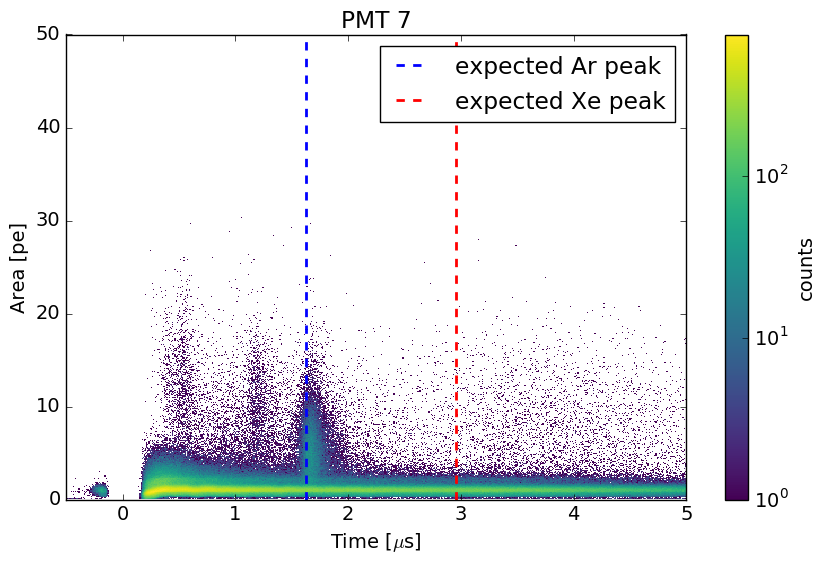

1774it [00:00, 17734.18it/s]

processed_wf3_Board0_AP_LED_2.3V.root


250000it [00:10, 23114.77it/s]


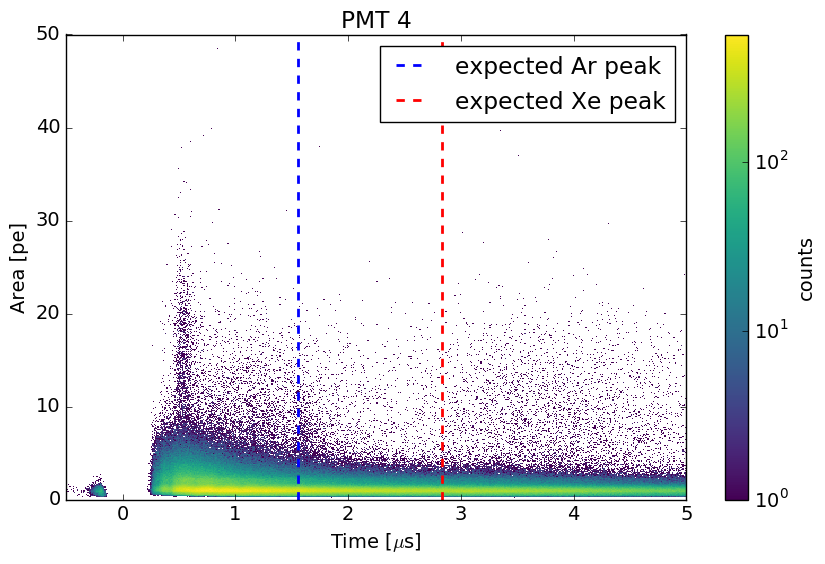

1857it [00:00, 18564.62it/s]

processed_wf5_Board0_AP_LED_2.09V.root


250000it [00:10, 23107.94it/s]


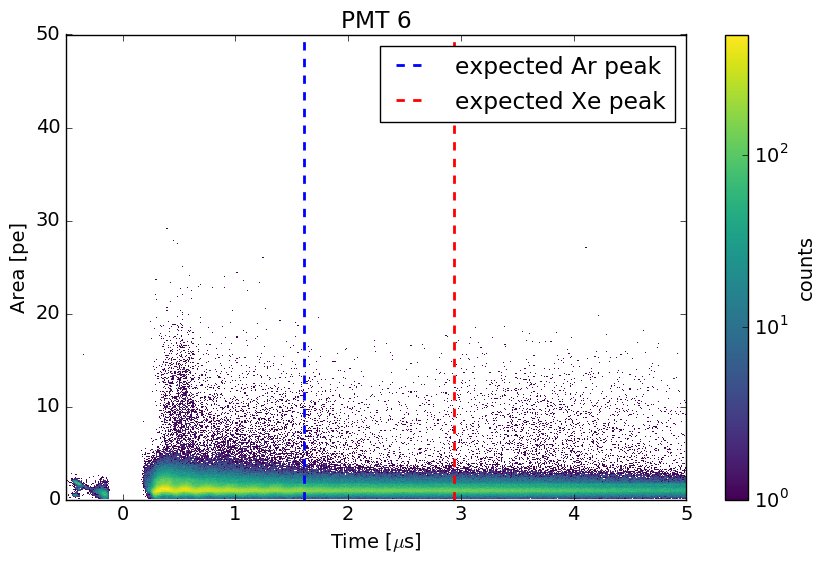

1633it [00:00, 16326.43it/s]

processed_wf1_Board0_AP_LED_2.26V.root


250000it [00:11, 22639.24it/s]


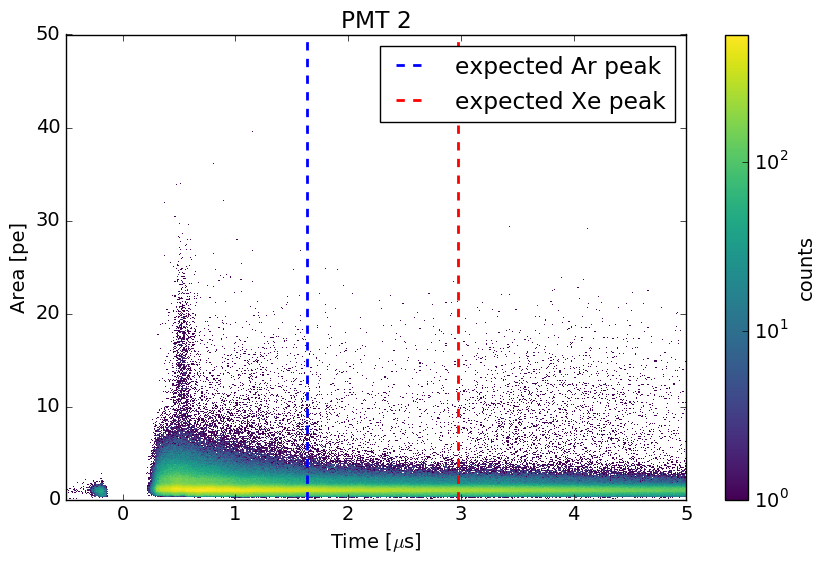

1540it [00:00, 15390.88it/s]

processed_wf0_Board0_AP_LED_2.205V.root


250000it [00:10, 23551.62it/s]


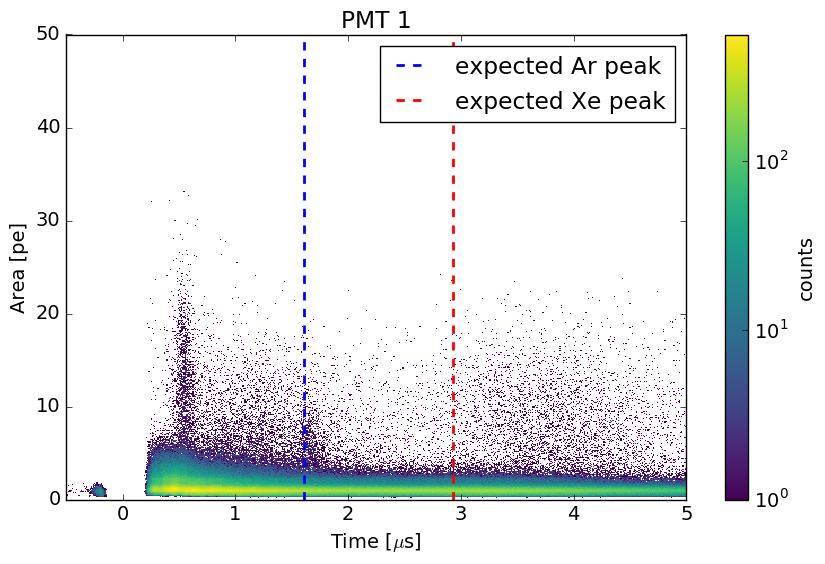

1665it [00:00, 16641.92it/s]

processed_wf2_Board0_AP_LED_2.26V.root


250000it [00:10, 22823.03it/s]


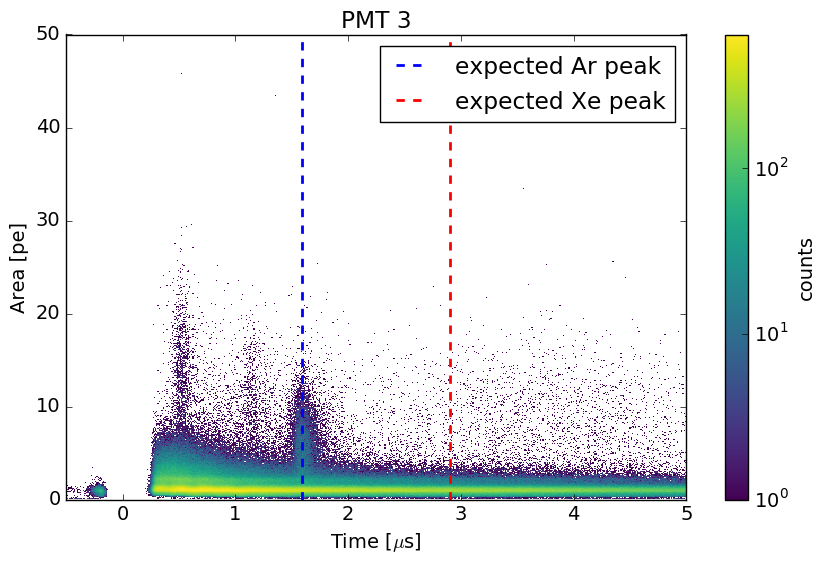

1285it [00:00, 12840.00it/s]

processed_wf4_Board0_AP_LED_2.3V.root


250000it [00:11, 22203.96it/s]


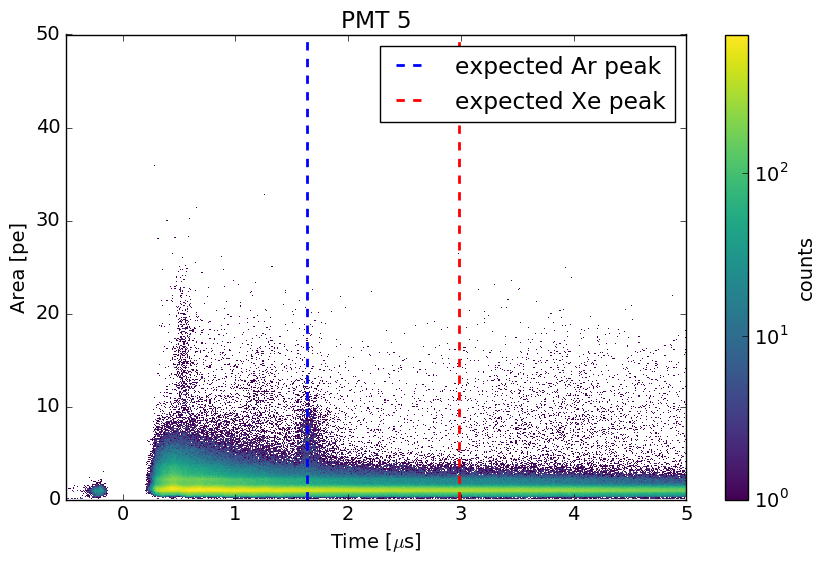

In [11]:
arHV5e6 = [1417.8,1377.6,1450.1,1521.4,1375.0,1416.9,1400,1431,1356.3,1419.9,1357.5,1379.3,1356.6,1468.4]
#[1429.7,1486.4,1456.8,1481.6,1490.7,1503.3,1399.0,1434.8,1432.6,1454.7,1469.1,1384.7,1453.5,1449.0] # insert the numerical values for the 5e6HV
arr=np.array(arHV5e6)

for file in os.listdir(path):
    if 'counts' in file:
        continue
    if 'AP_figs' in file:
        continue
    print(file)
    channel = int(file.split("_")[1].lstrip("wf"))
    board = int(file.split("_")[2].lstrip("Board"))
    pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

    AP_data = process_ap_file(path + file)
    #plot_hw(AP_data,pmt)
    plot(AP_data, pmt , arr[pmt-1])
    #plt.savefig('ap_pmt%d_run0_vacuum.png' % pmt, dpi=150)
    

In [ ]:
##############      SKIP TO LAST CELL IF YOU ONLY WANT THE COUNTS    ################

In [16]:
def fit_exp(x, N, a, c1, c2):
    return N*np.exp(-a*x + c1) + c2

def plot1dhist(data_frame,pmt,func,valHV5e6):
    plt.figure(figsize=(10,6))
    data_frame1=data_frame[(data_frame['area']<50)]
    weights = np.ones_like(data_frame1['time'])/float(len(data_frame['time'])) # normalized to ALL events (above 2pe th.)
    h, bin_edges, _= plt.hist( data_frame1['time'], bins=500, range=((0, 5)), normed = False, weights = weights) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[(histDF['bin_centres']<1.3) | (histDF['bin_centres']>4)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    #res = curve_fit(func, bin_centers, h1, p0=[500,1, 1, 0])
    XePeak = estimateXePosition(valHV5e6)
    ArPeak = estimateArPosition(valHV5e6)
    plt.axvline(ArPeak, color='b', linestyle='dashed', linewidth=2, label = 'expected Ar peak')
    plt.axvline(XePeak, color='red', linestyle='dashed', linewidth=2, label = 'expected Xe peak')
    plt.legend(loc = 'upper right')
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('events/triggers')
    plt.title('PMT %d' % pmt)
    #plt.plot(bin_centres, func(bin_centres, *res[0]))
    #plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_noth_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    """residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp-fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-100,200])
    #plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_expfit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()
    """

250000it [00:10, 24739.32it/s]


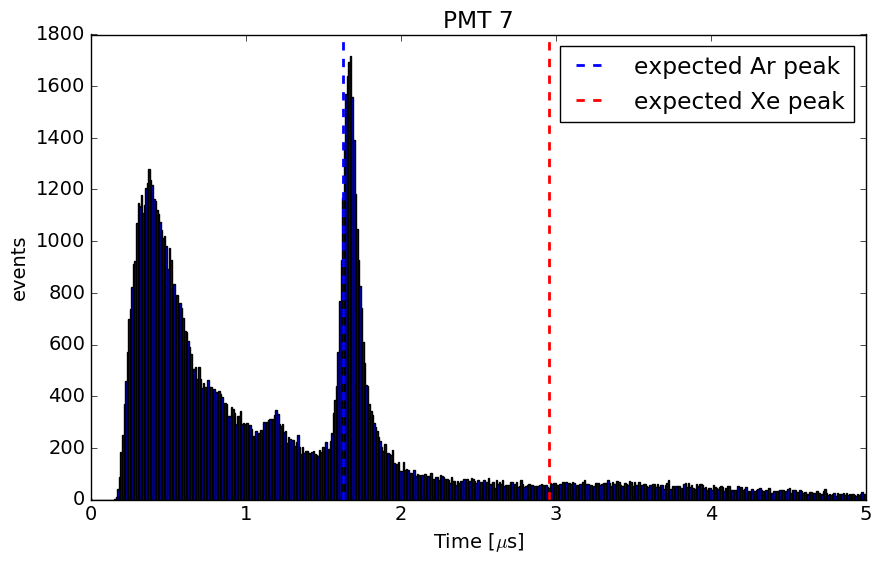

250000it [00:10, 23477.49it/s]


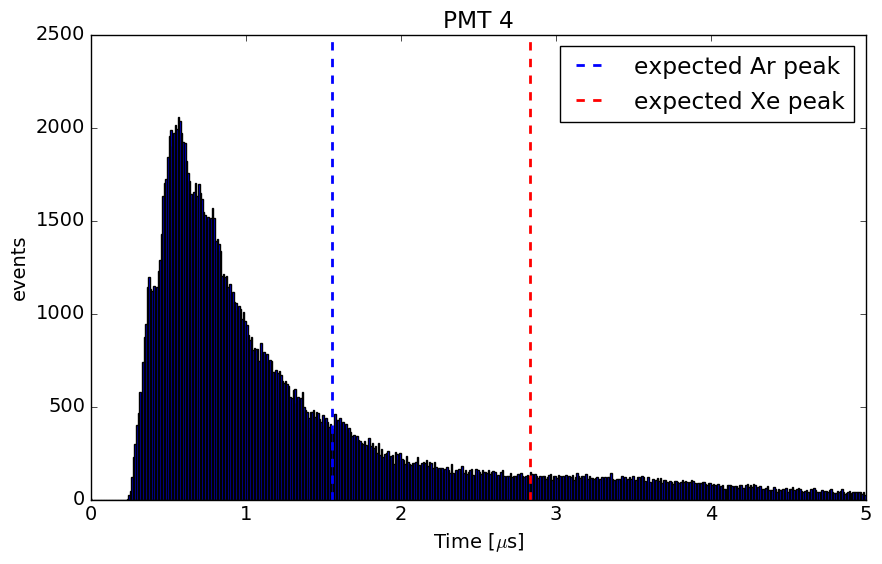

250000it [00:09, 25005.44it/s]


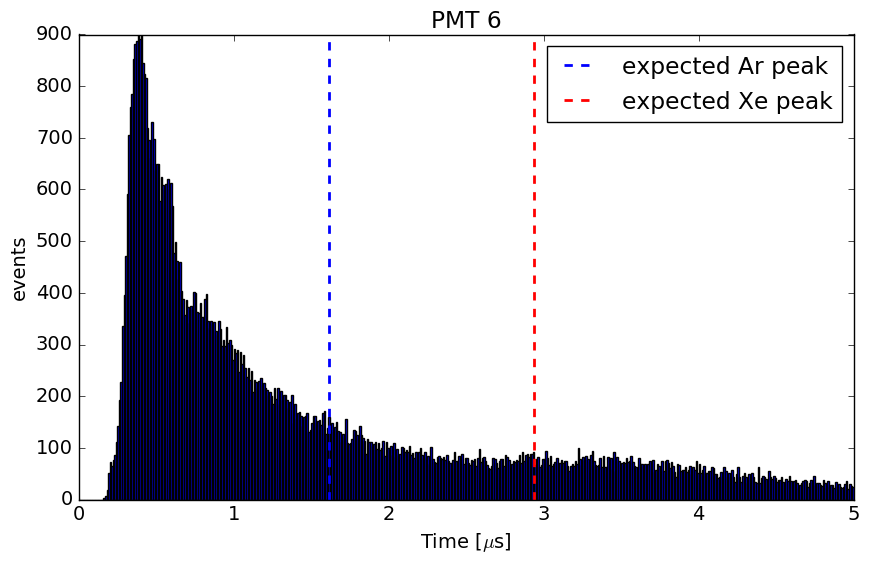

250000it [00:10, 24175.21it/s]


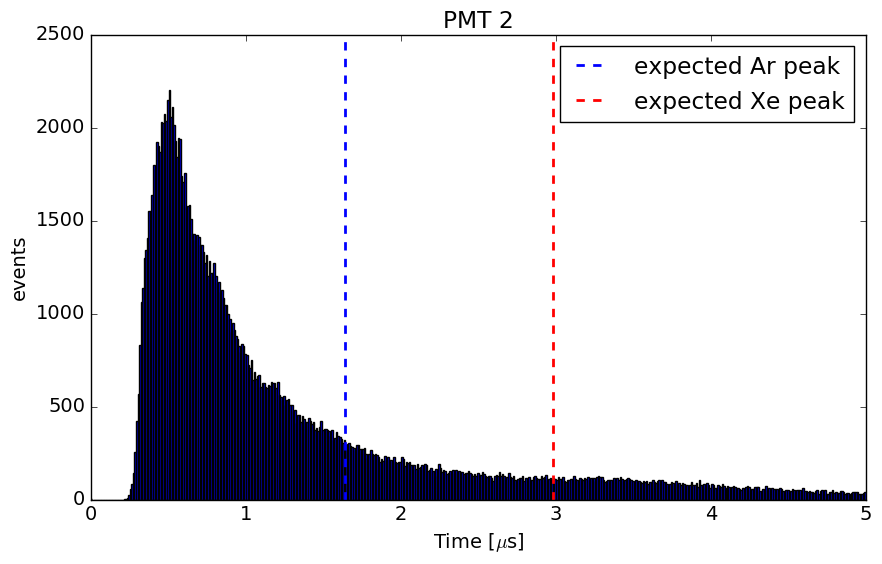

250000it [00:10, 24834.85it/s]


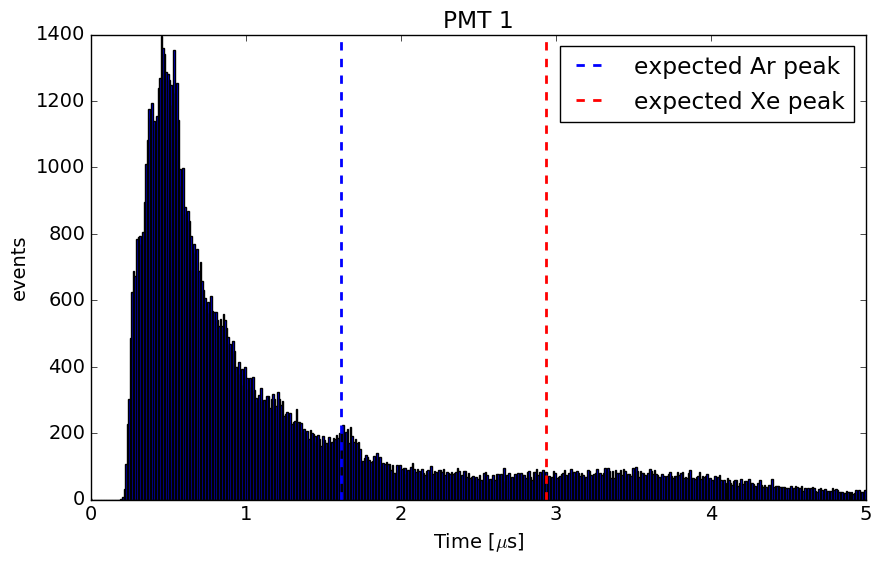

250000it [00:10, 24138.99it/s]


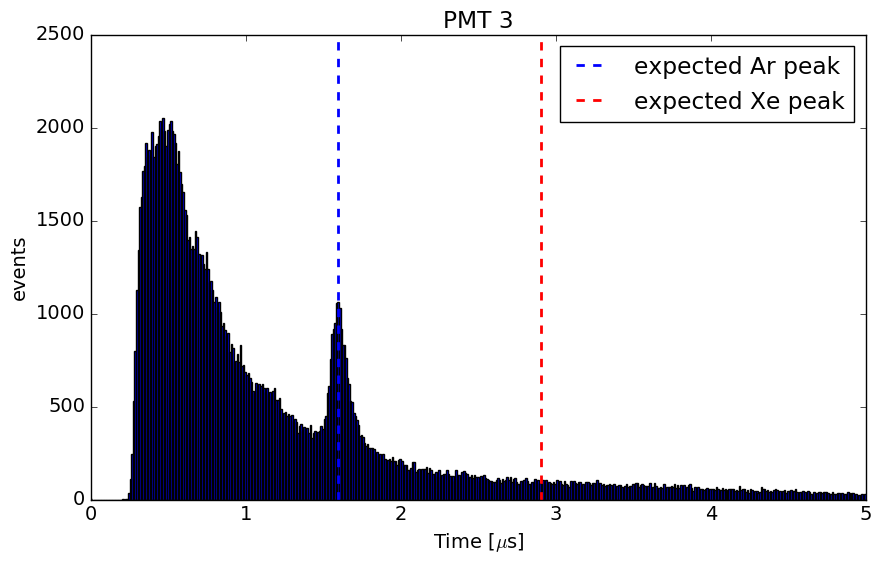

250000it [00:10, 23955.50it/s]


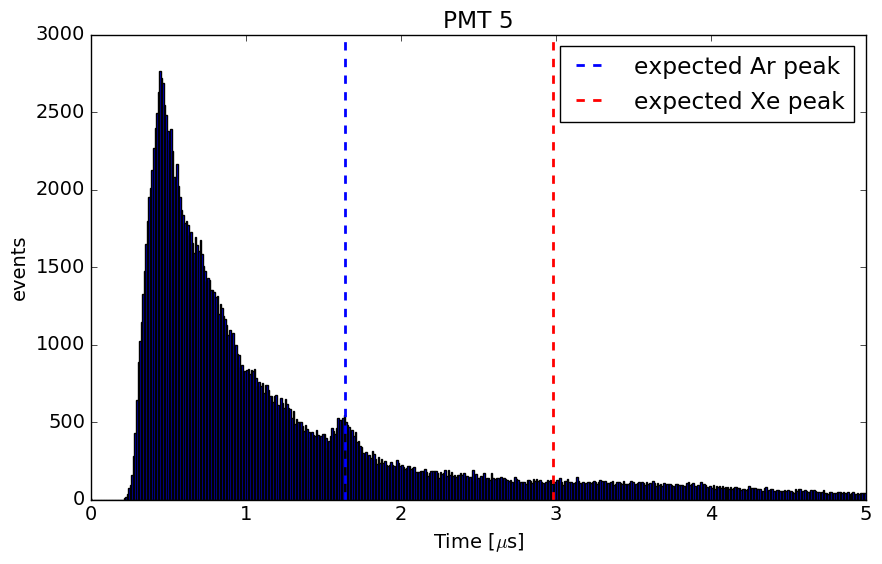

In [17]:
for file in os.listdir(path):
    if 'counts' in file:
        continue
    if 'AP_figs' in file:
        continue
    #print(file)
    channel = int(file.split("_")[1].lstrip("wf"))
    board = int(file.split("_")[2].lstrip("Board"))
    pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

    AP_data = process_ap_file(path + file)
    #AP_data = AP_data[AP_data['entropy']<0.4]
    plot1dhist(AP_data[AP_data['area']>2.],pmt,fit_exp,arr[pmt-1])
    

In [207]:
def fit_exp_gaus(x, Ne, a, c1, c2, Ng, sigma, mu):
    return Ne*np.exp(-a*x + c1) + c2 + Ng*sps.norm.pdf(x, loc=mu, scale = sigma)

def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[(histDF['bin_centres']>0.7)]#|(histDF['bin_centres']<0.9)) | (histDF['bin_centres']>1.6)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[800,2, 2, 10, 100, 1, 3.2])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()

250000it [00:04, 54370.19it/s]


539.009760111 1.68274785724 0.936542878778 20.153874408 32.3471503768 0.608816070267 3.3953109265


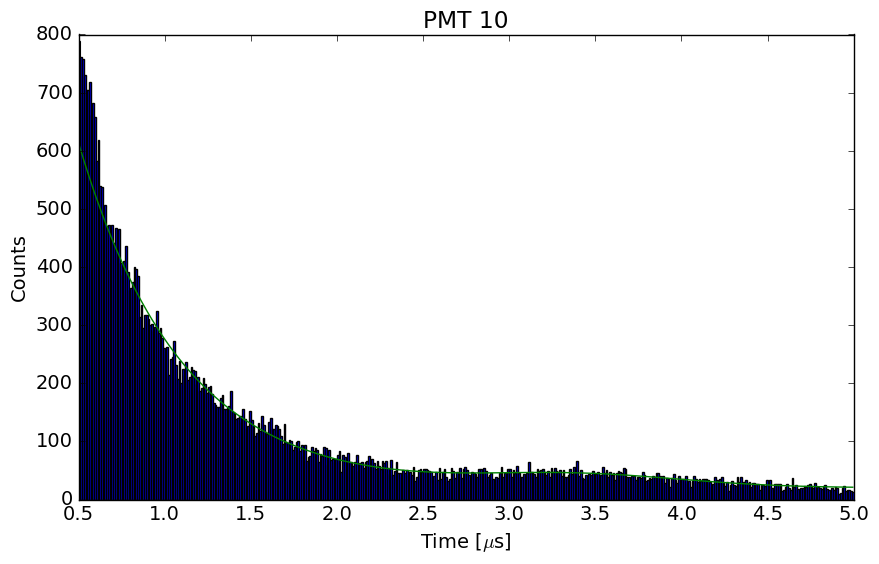

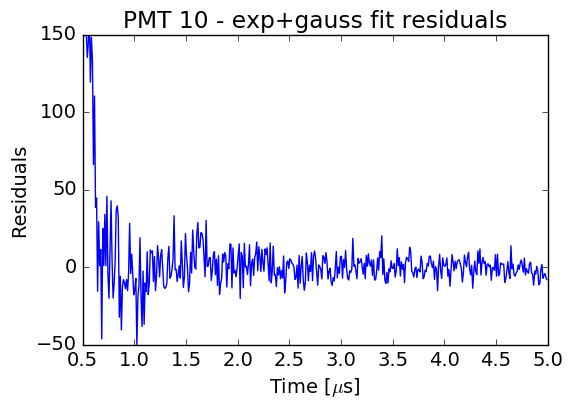

In [208]:
#for file in os.listdir(path):
#   if 'counts' in file:
#    continue
    #print(file)
file = os.listdir(path)[0]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

250000it [00:05, 47870.71it/s]


747.896522966 1.99068017047 2.07677374881 -861.727266058 11786.3194013 4.77527284594 2.82982094165


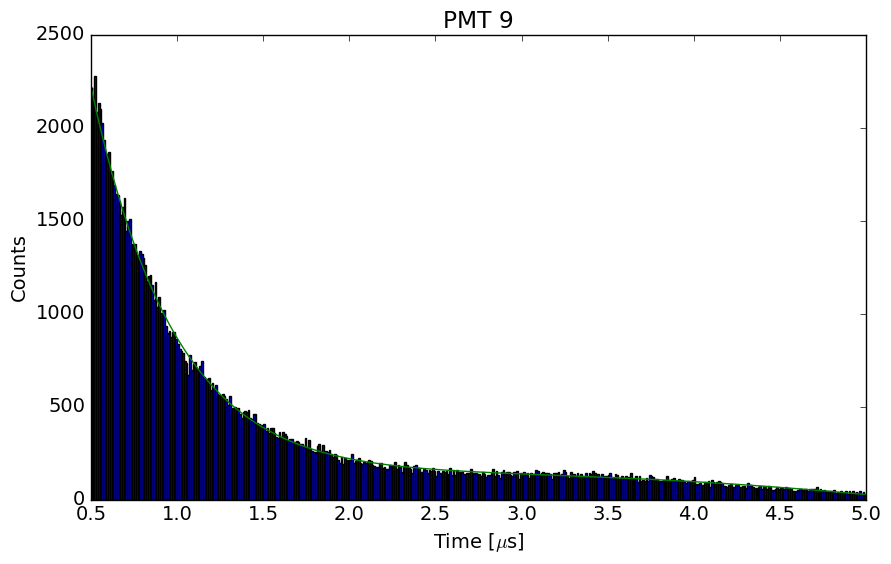

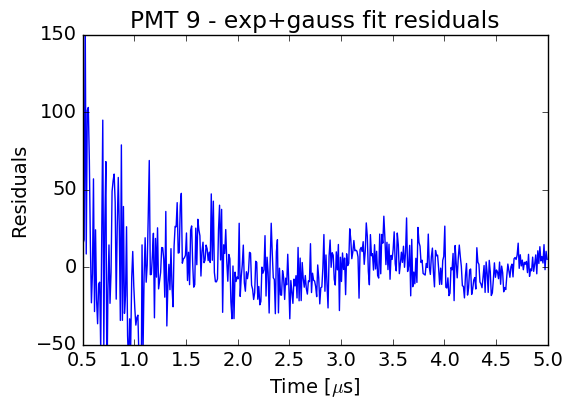

In [209]:
file = os.listdir(path)[1]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

250000it [00:05, 46077.27it/s]


4415.00679891 1.72473198238 0.354256320777 4.23700222845 442.282762486 1.45197632073 2.80873586021


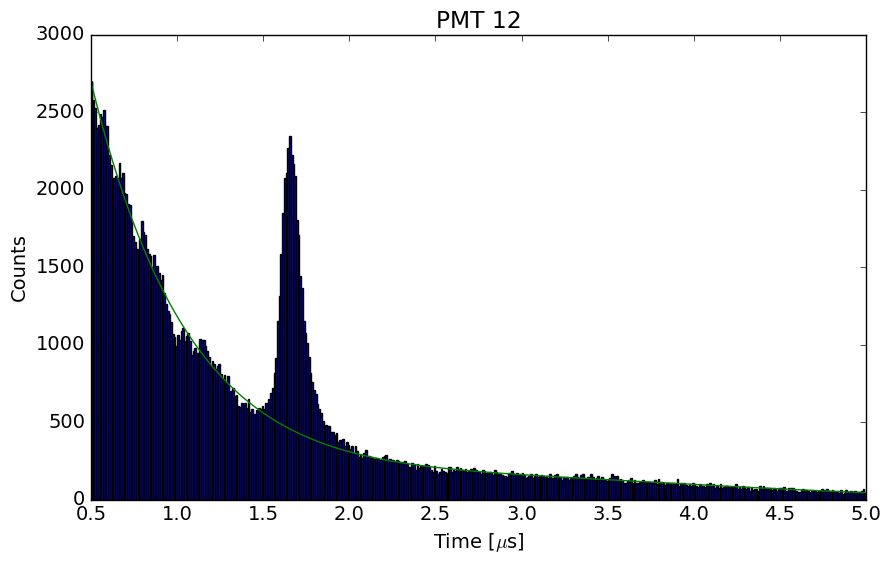

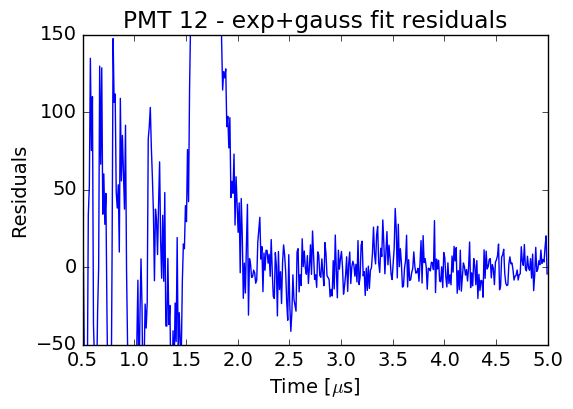

In [210]:
def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[((histDF['bin_centres']>0.5)&(histDF['bin_centres']<1.3)) | (histDF['bin_centres']>2)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[800,1.7, 1, 0, 100, 1, 3.2])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()
    
file = os.listdir(path)[2]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

250000it [00:04, 52288.30it/s]


735.058500322 1.58574428401 0.759361687824 -295.86226027 3142.63107714 3.62687402747 3.33431078549


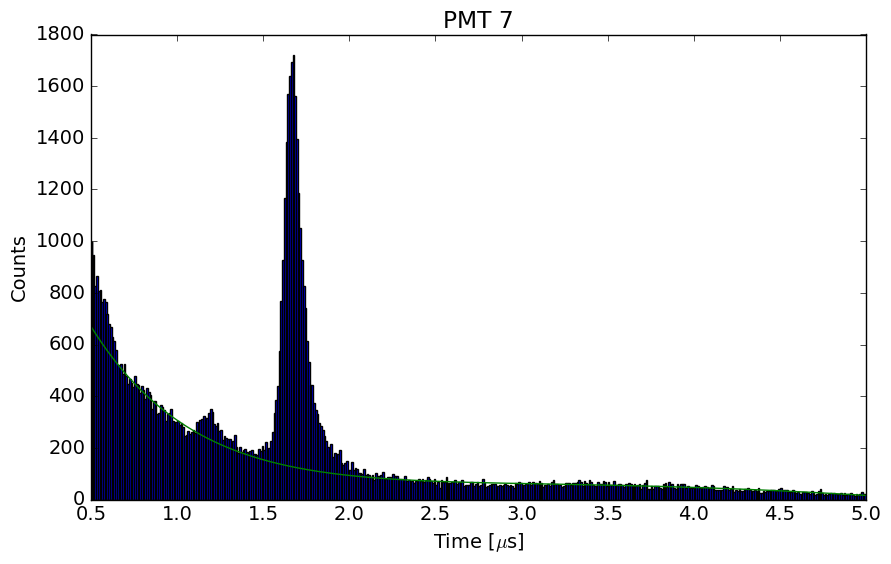

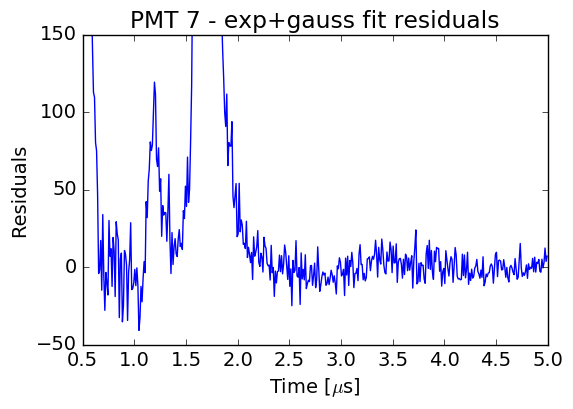

In [211]:
def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[((histDF['bin_centres']>0.65) &(histDF['bin_centres']<0.95 )) | (histDF['bin_centres']>2.1)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[880, 1.3, 1.4, 38, 200, 1.5, 3.3])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()
    
file = os.listdir(path)[3]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

250000it [00:05, 42586.55it/s]


664.623216962 1.90482076636 2.2531731479 -7.40688524023 387.063533861 1.35045866974 3.03282150376


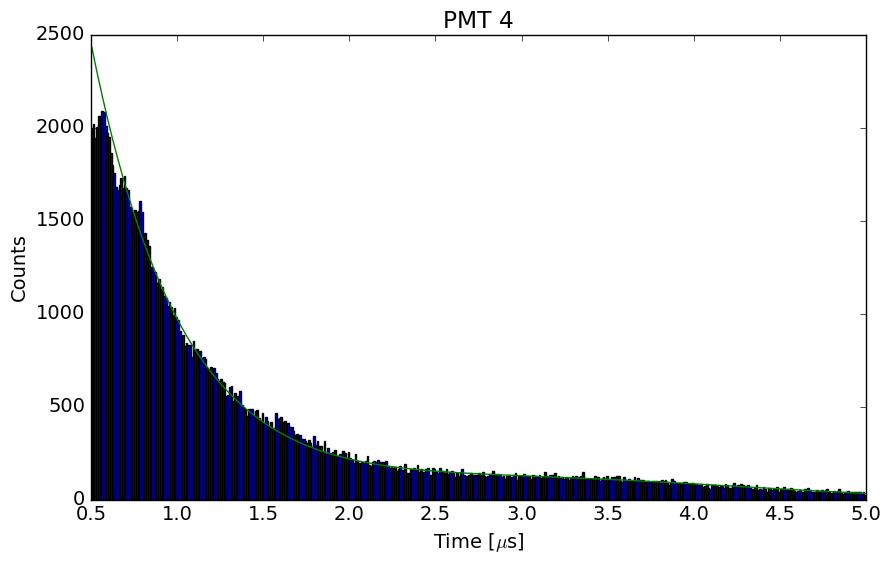

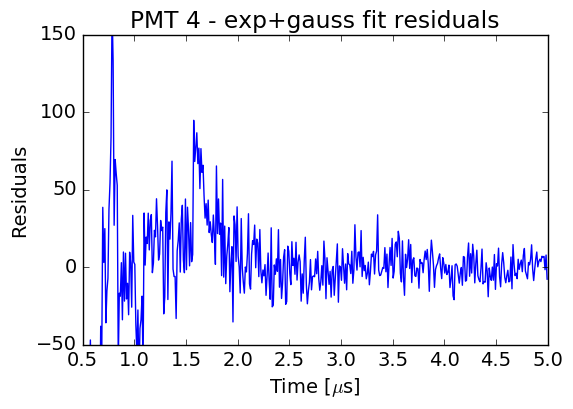

In [212]:
def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[((histDF['bin_centres']>0.8) &(histDF['bin_centres']<1.3 )) | (histDF['bin_centres']>2.1)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[400, 1, 2, 0, 1000, 1, 2])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()

file = os.listdir(path)[4]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

250000it [00:05, 43695.99it/s]


736.760937043 1.60991569056 1.87207985485 17.4261561205 240.294845685 1.28259325648 2.73018875141


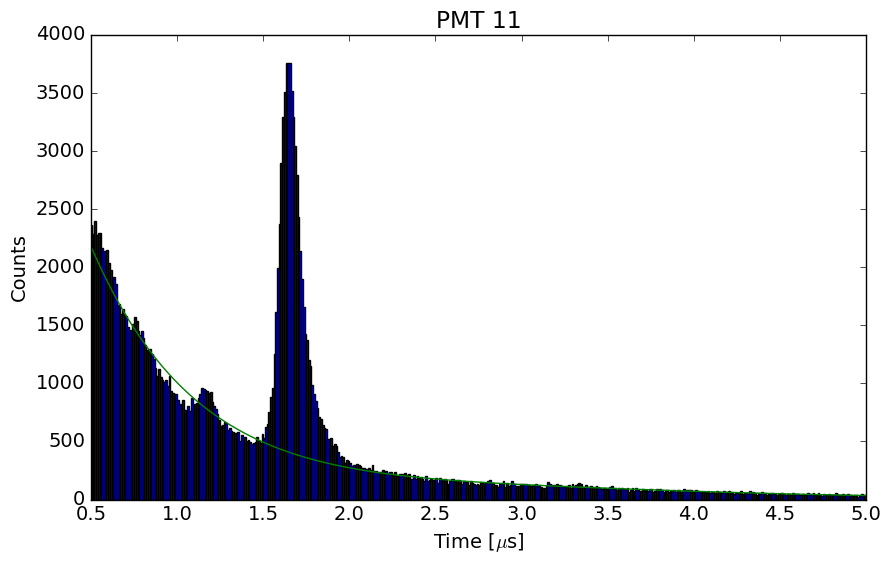

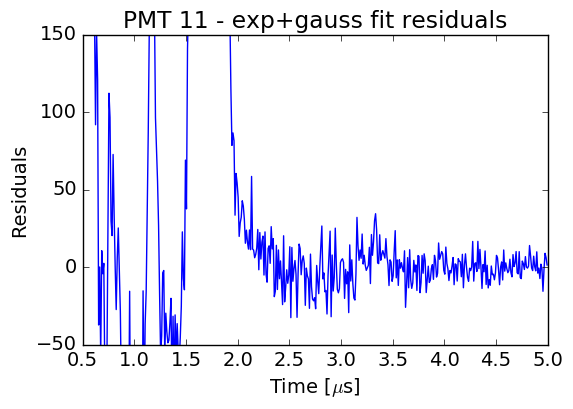

In [213]:
def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[((histDF['bin_centres']>1.27) &(histDF['bin_centres']<1.33 ))|((histDF['bin_centres']>0.65) &(histDF['bin_centres']<0.85 )) | (histDF['bin_centres']>2.1)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[900, 2, 2, 16, 1, 1000, 3.])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()

file = os.listdir(path)[6]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

In [160]:
os.listdir(path)

['processed_wf2_Board1_AP_LED_2.205V.root',
 'processed_wf1_Board1_AP_LED_2.25V.root',
 'processed_wf4_Board1_AP_LED_2.315V.root',
 'processed_wf6_Board0_AP_LED_2.12V.root',
 'processed_wf3_Board0_AP_LED_2.3V.root',
 'processed_wf0_Board1_AP_LED_2.205V.root',
 'processed_wf3_Board1_AP_LED_2.315V.root',
 'processed_wf5_Board1_AP_LED_2.12V.root',
 'AP_figs',
 'counts',
 'processed_wf5_Board0_AP_LED_2.09V.root',
 'processed_wf1_Board0_AP_LED_2.26V.root',
 'processed_wf6_Board1_AP_LED_2.12V.root',
 'processed_wf0_Board0_AP_LED_2.205V.root',
 'processed_wf2_Board0_AP_LED_2.26V.root',
 'processed_wf4_Board0_AP_LED_2.3V.root']

250000it [00:05, 49717.10it/s]


540.121011424 1.68004269856 1.49663258582 15.2390721315 121.490721104 0.829686281549 3.3765683249


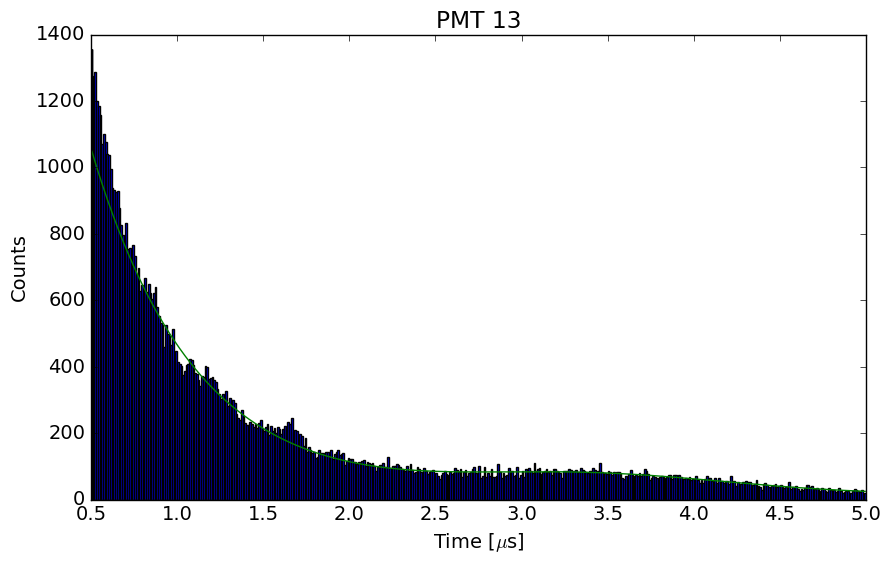

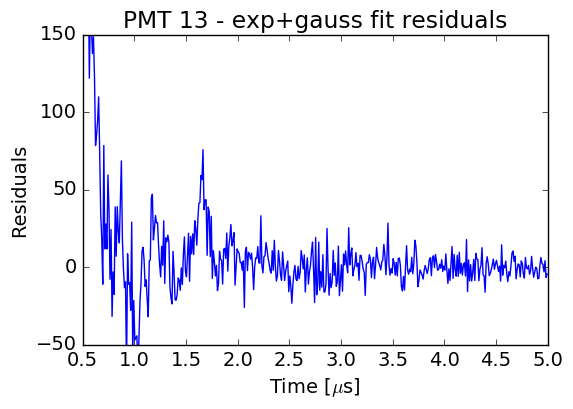

In [214]:
def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[((histDF['bin_centres']>0.8) &(histDF['bin_centres']<1.3 )) | (histDF['bin_centres']>2.1)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[800, 2, 2, 10, 200, 2, 3.3])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()

file = os.listdir(path)[7]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

#quite bad fit values... gaussian mean @1.98 (??!!)

250000it [00:04, 53017.21it/s]


418.626028652 1.65701814444 1.73170089618 14.2556627982 126.68169005 0.857319867775 3.36955454074


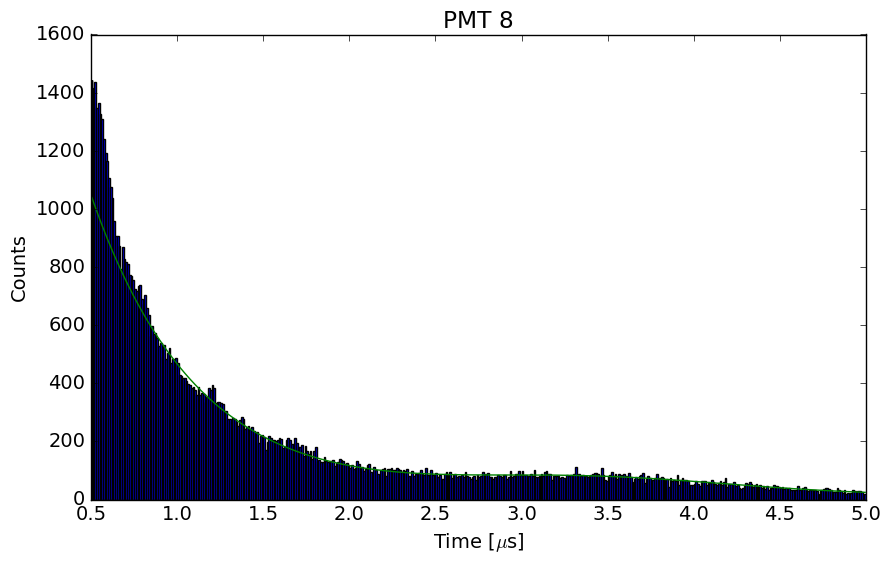

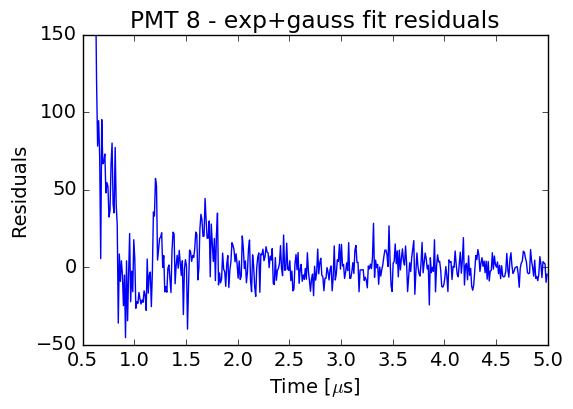

In [215]:
def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[((histDF['bin_centres']>0.8) &(histDF['bin_centres']<1.3 )) | (histDF['bin_centres']>1.8)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[600, 2, 2, 0, 150, 2, 3.0])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()

file = os.listdir(path)[5]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

250000it [00:04, 51493.55it/s]


265.614724132 1.43187459728 1.4614480793 14.8693222753 120.455410891 0.941309303621 3.34985696964


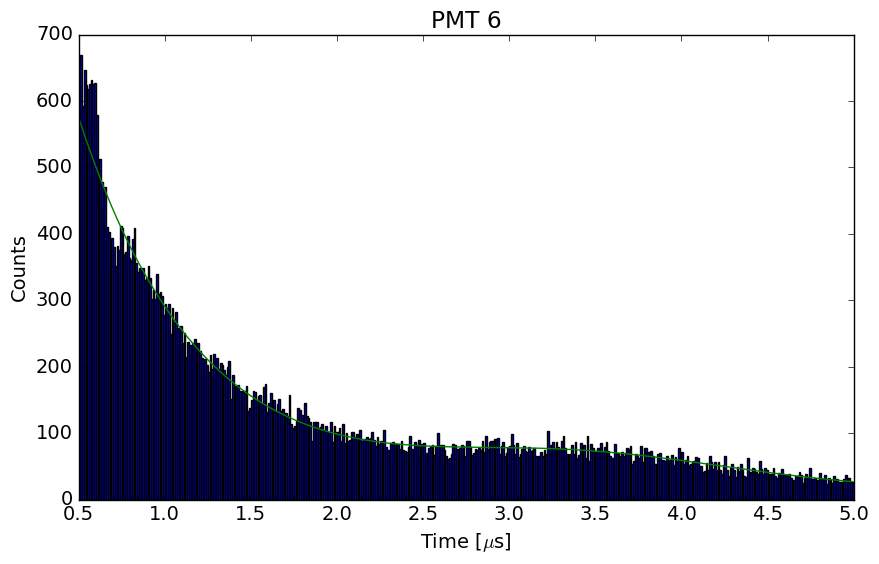

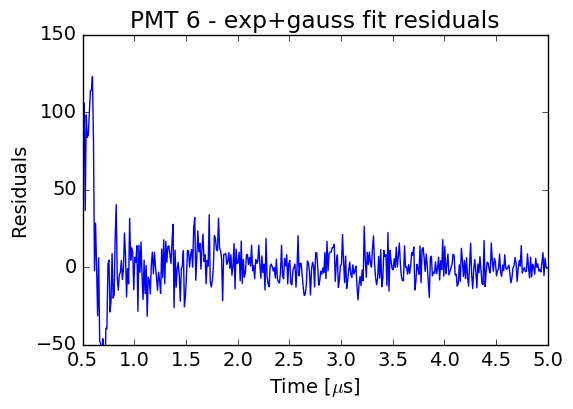

In [216]:
def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[((histDF['bin_centres']>0.8) &(histDF['bin_centres']<1.3 )) | (histDF['bin_centres']>1.8)]#define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[600, 2, 2, 0, 150, 2, 3.5])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()

file = os.listdir(path)[10]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

250000it [00:05, 47653.53it/s]


763.5436635 1.87593471726 1.87246439947 -398.236579513 4976.14495553 3.99973071555 2.77316600549


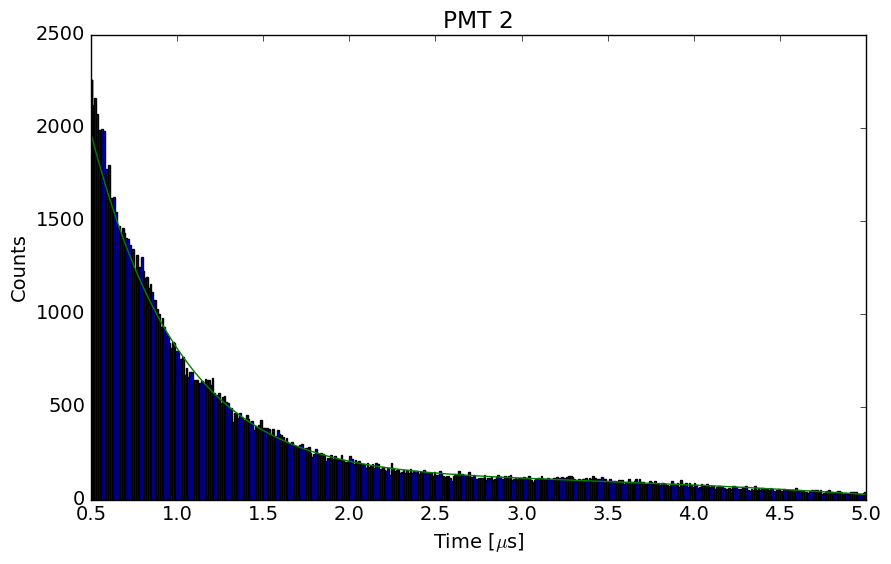

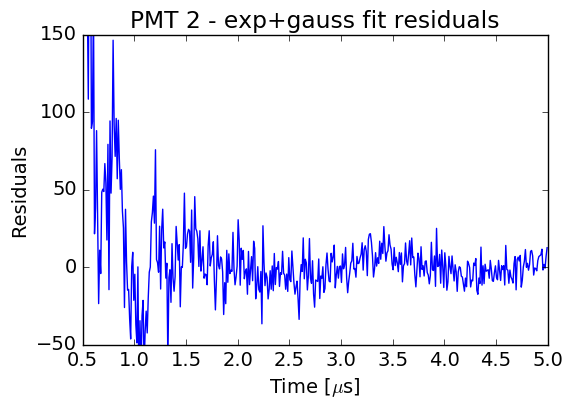

In [219]:
def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[(histDF['bin_centres']>0.85)]# &(histDF['bin_centres']<1.3 )) | (histDF['bin_centres']>1.8)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[700, 2, 2, 10, 100, 1, 3.3])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()

file = os.listdir(path)[11]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

250000it [00:05, 48056.44it/s]


432.423251233 1.60938789846 1.3763517444 -3.86889928427 153.89374975 1.13222874795 3.46226885485


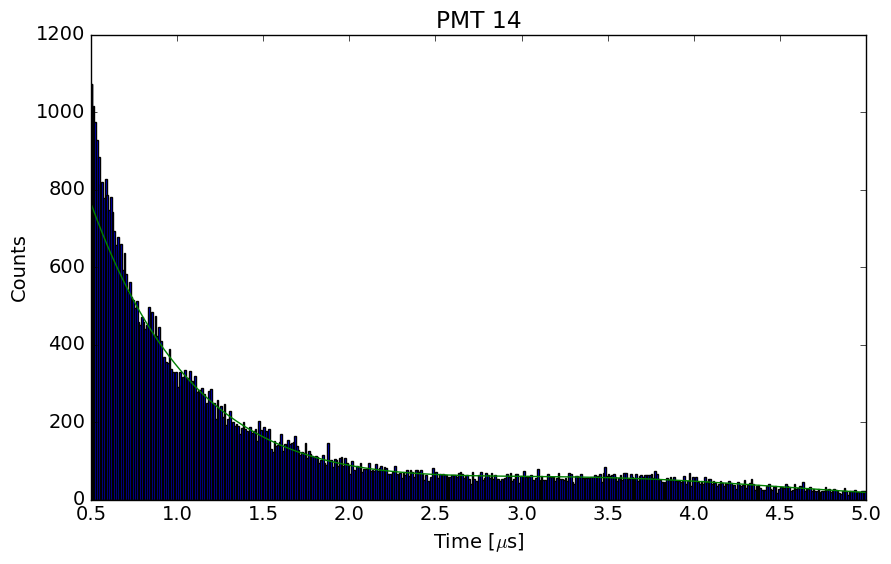

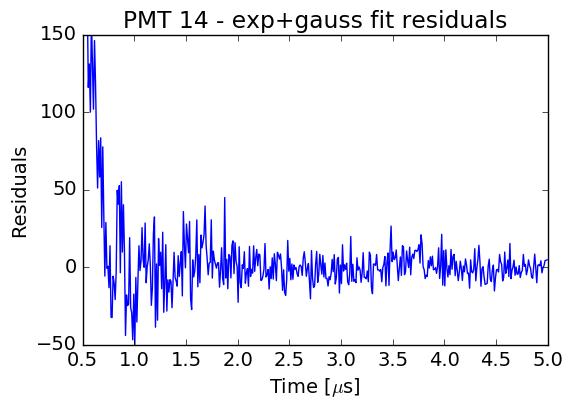

In [221]:
def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[(histDF['bin_centres']>0.7)] #| (histDF['bin_centres']>1.8)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[400, 1.7, 1, 0, 100, 1, 3.5])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()

file = os.listdir(path)[12]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

250000it [00:05, 48098.54it/s]


891.292978502 1.89461076219 1.08009990228 -16.7788839159 273.752730373 1.18610527414 3.34042507749


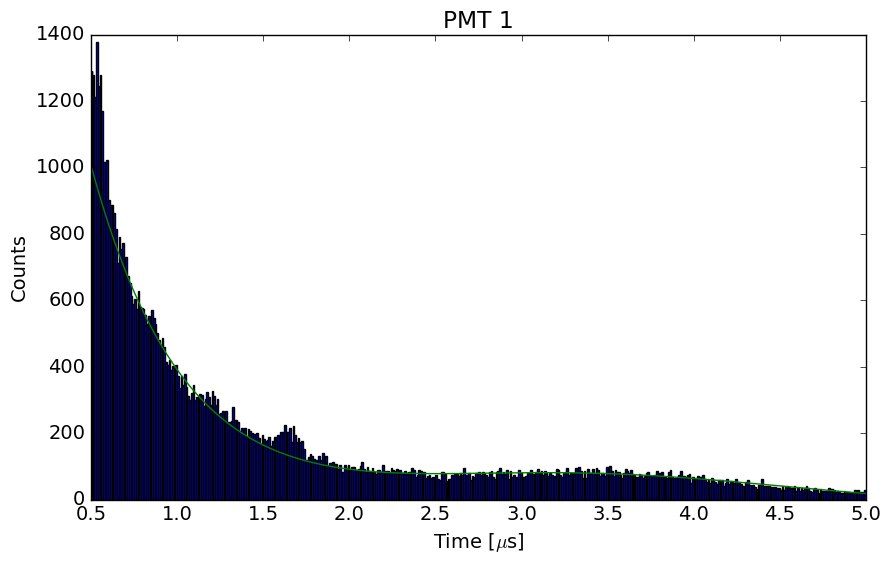

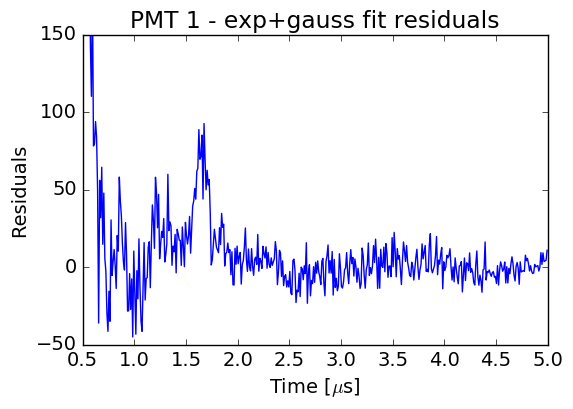

In [223]:
def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[((histDF['bin_centres']>0.7)&(histDF['bin_centres']<1.2)) | (histDF['bin_centres']>1.9)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[600, 2, 1, 0, 150, 1.5, 3.3])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()
    
file = os.listdir(path)[13]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

250000it [00:05, 46700.22it/s]


552.454964262 1.45220410125 1.6824372158 22.4460412303 76.8483213627 0.812928959498 3.42992802507


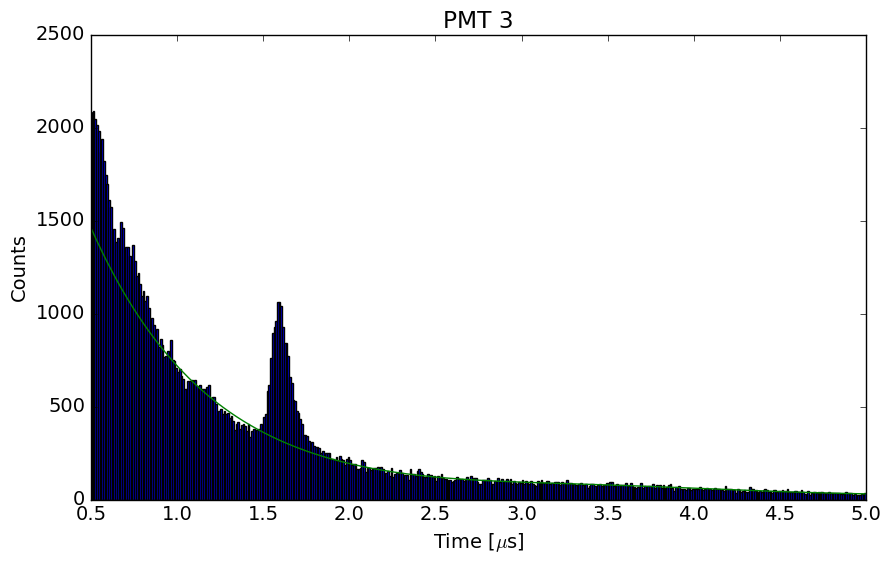

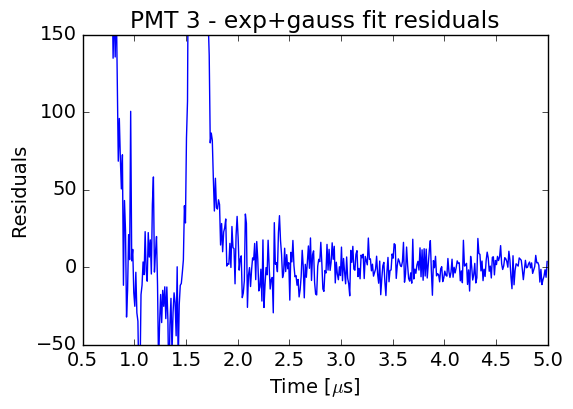

In [242]:
def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[((histDF['bin_centres']>0.89)&(histDF['bin_centres']<1.2) )| (histDF['bin_centres']>2.)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[900, 2, 2 , 0, 100, 1.2, 3.4])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()

file = os.listdir(path)[14]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

250000it [00:05, 45221.57it/s]


4602.37763538 2.04058270857 0.352102058696 -111.054654931 1354.13950292 2.44549084269 2.77216520669


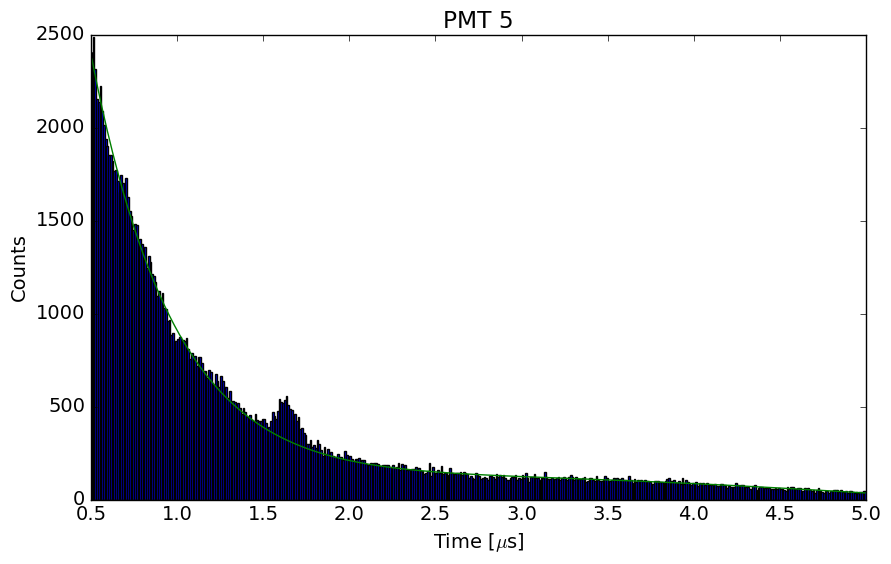

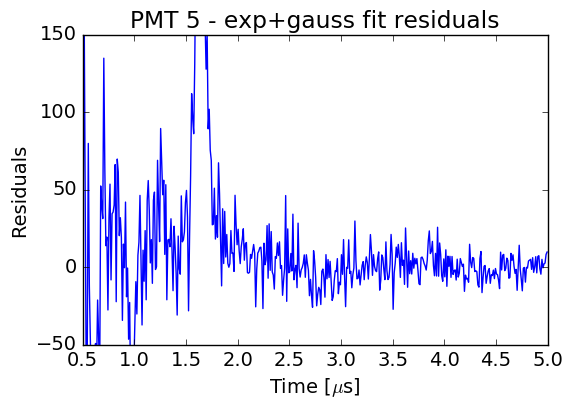

In [244]:
def plot1dhist(data_frame,pmt,func):
    plt.figure(figsize=(10,6))
    h, bin_edges, _= plt.hist( data_frame['time'] , bins=450, range=((0.5, 5.0))) #norm=LogNorm()) #bins 200
    #plt.colorbar(label='counts')
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    histDF=histDF[(histDF['bin_centres']<1.) | (histDF['bin_centres']>2.1)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[1500, 2, 2, 1, 100, 1, 3])

    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Counts')
    plt.title('PMT %d' % pmt)
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(*res[0])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_run2_gas.png' % pmt, dpi=150)
    plt.show()
    plt.clf()
    
    residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp+gauss fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-50,150])
    plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_exp_gauss_fit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()

file = os.listdir(path)[15]
channel = int(file.split("_")[1].lstrip("wf"))
board = int(file.split("_")[2].lstrip("Board"))
pmt = channel + 1 + board * 7
    #print(channel,board, pmt)

AP_data = process_ap_file(path + file)
plot1dhist(AP_data[AP_data['area']>2],pmt,fit_exp_gaus)

In [245]:
all_files = os.listdir(path)
outfile = open(path+'counts/'+'counts.txt', 'w')
outfile.write("######################\n")
outfile.write("The numbers are as folows:\n")
outfile.write("PMT#\n")
outfile.write("Counts in left sideband (2.31 to 2.67)#\n")
outfile.write("Counts in left sideband (2.4 to 2.67)#\n")
outfile.write("Counts in left sideband (2.49 to 2.67)#\n")
outfile.write("Counts in left sideband (2.58 to 2.67)#\n")
outfile.write("Counts in right sideband (3.03 to 3.12)#\n")
outfile.write("Counts in right sideband (3.03 to 3.21)#\n")
outfile.write("Counts in right sideband (3.03 to 3.3)#\n")
outfile.write("Counts in left sideband (3.03 to 3.39)#\n")
outfile.write("Counts in signalband (2.67 to 3.03)#\n")
outfile.write("Threshold\n")
outfile.write("######################\n")
for file in os.listdir(path):
    if 'counts' in file:
        continue
    if 'AP_figs' in file:
        continue
    
    threshold=2
    filename = file
    channel = int(file.split("_")[1].lstrip("wf"))
    board = int(file.split("_")[2].lstrip("Board"))
    pmt = channel + 1 + board * 7
    print(path + filename)
    DataFrame = process_ap_file(path + filename)
    
    """
    def apply_selection(row):
        global counter_sig
        global counter_up1
        global counter_up2
        global counter_up3
        global counter_low1
        global counter_low2
        global counter_low3
        pos_j = row.time/100. -2.
        if not row.area > threshold:
            return
        if pos_j<2.67 and pos_j>2.4:
            counter_low1 +=1
        if pos_j<2.67 and pos_j>2.49:
            counter_low2 +=1
        if pos_j<2.67 and pos_j>2.58:
            counter_low3 +=1
        if pos_j<3.12 and pos_j>3.03:
            counter_up1 +=1
        if pos_j<3.21 and pos_j>3.03:
            counter_up2 +=1
        if pos_j<3.3 and pos_j>3.03:
            counter_up3 +=1
        if pos_j<3.03 and pos_j>2.67:
            counter_sig +=1
        return
    
    DataFrame.apply(apply_selection, axis=1)
    """
    
    above_threshold = DataFrame[DataFrame.area > threshold]
    
    
    counter_low1 = ((above_threshold.time/100.-2. > 2.4) & (above_threshold.time/100.-2. < 2.67)).sum()
    counter_low2 = ((above_threshold.time/100.-2. > 2.49) & (above_threshold.time/100.-2. < 2.67)).sum()
    counter_low3 = ((above_threshold.time/100.-2. > 2.58) & (above_threshold.time/100.-2. < 2.67)).sum()
    counter_low4 = ((above_threshold.time/100.-2. > 2.31) & (above_threshold.time/100.-2. < 2.67)).sum()
    
    counter_up1 = ((above_threshold.time/100.-2. > 3.03) & (above_threshold.time/100.-2. < 3.12)).sum()
    counter_up2 = ((above_threshold.time/100.-2. > 3.03) & (above_threshold.time/100.-2. < 3.21)).sum()
    counter_up3 = ((above_threshold.time/100.-2. > 3.03) & (above_threshold.time/100.-2. < 3.3)).sum()
    counter_up4 = ((above_threshold.time/100.-2. > 3.03) & (above_threshold.time/100.-2. < 3.39)).sum()
    
    counter_sig = ((above_threshold.time/100.-2. > 2.67) & (above_threshold.time/100.-2. < 3.03)).sum()

    
    """
    for j in range(len(DataFrame['time'])):
        pos_j=DataFrame.time[j]/100.-2.
        area_j=DataFrame.area[j]
        #print(pos_j,area_j)
        if pos_j<2.67 and pos_j>2.4 and area_j>threshold:
            counter_low1 +=1
        if pos_j<2.67 and pos_j>2.49 and area_j>threshold:
            counter_low2 +=1
        if pos_j<2.67 and pos_j>2.58 and area_j>threshold:
            counter_low3 +=1
        if pos_j<3.12 and pos_j>3.03 and area_j>threshold:
            counter_up1 +=1
        if pos_j<3.21 and pos_j>3.03 and area_j>threshold:
            counter_up2 +=1
        if pos_j<3.3 and pos_j>3.03 and area_j>threshold:
            counter_up3 +=1
        if pos_j<3.03 and pos_j>2.67 and area_j>threshold:
            counter_sig +=1
    """
    #plot(DataFrame, pmt)
    outfile.write("%d %d %d %d %d %d %d %d %d %d %d\n" % (pmt,counter_low4,counter_low1,counter_low2,counter_low3,counter_up1,counter_up2,counter_up3,counter_up4,counter_sig,threshold))
outfile.close()



2183it [00:00, 21825.70it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf2_Board1_AP_LED_2.205V.root


250000it [00:04, 52900.24it/s]
3634it [00:00, 36325.23it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf1_Board1_AP_LED_2.25V.root


250000it [00:05, 49465.81it/s]
3507it [00:00, 35063.01it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf4_Board1_AP_LED_2.315V.root


250000it [00:04, 50172.18it/s]
3298it [00:00, 32973.82it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf6_Board0_AP_LED_2.12V.root


250000it [00:04, 52597.04it/s]
3952it [00:00, 39350.23it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf3_Board0_AP_LED_2.3V.root


250000it [00:05, 47684.35it/s]
3469it [00:00, 34678.95it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf0_Board1_AP_LED_2.205V.root


250000it [00:04, 50476.57it/s]
3063it [00:00, 30621.41it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf3_Board1_AP_LED_2.315V.root


250000it [00:05, 49697.47it/s]
3165it [00:00, 31417.15it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf5_Board1_AP_LED_2.12V.root


250000it [00:04, 52382.30it/s]
3645it [00:00, 36272.83it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf5_Board0_AP_LED_2.09V.root


250000it [00:04, 54624.20it/s]
3260it [00:00, 32561.22it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf1_Board0_AP_LED_2.26V.root


250000it [00:04, 50620.72it/s]
4222it [00:00, 42181.92it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf6_Board1_AP_LED_2.12V.root


250000it [00:04, 53907.50it/s]
3462it [00:00, 34607.00it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf0_Board0_AP_LED_2.205V.root


250000it [00:04, 54296.31it/s]
3699it [00:00, 36980.60it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf2_Board0_AP_LED_2.26V.root


250000it [00:04, 50647.01it/s]
3059it [00:00, 30452.52it/s]

/home/cristian/Suxess_files/data/AP171027/processed/run2/gas_final/processed_wf4_Board0_AP_LED_2.3V.root


250000it [00:05, 49520.93it/s]
